In [2]:
# 时间序列预测ARIMA模型 - 案例二：商品销售预测
# Mathematical Modeling Course - Case Study 2: Product Sales Forecasting with Seasonality

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 统计分析库
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# 机器学习库
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools

# 设置中文显示和图形样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("=" * 60)
print("      时间序列预测ARIMA模型 - 商品销售预测案例")
print("=" * 60)


      时间序列预测ARIMA模型 - 商品销售预测案例


# ==========================================
# 第一步：生成带季节性的销售数据
# ==========================================

In [4]:
def generate_seasonal_sales_data(start_date='2022-01-01', periods=24):
    """
    生成具有趋势和季节性的月度销售数据
    模拟电商商品的销售模式：
    - 整体上升趋势
    - 11、12月销售高峰（双十一、双十二）
    - 2、3月销售低谷（春节效应）
    - 随机波动
    """
    np.random.seed(123)  # 保证结果可重复
    
    # 创建月度日期索引
    dates = pd.date_range(start=start_date, periods=periods, freq='M')
    
    # 基础趋势（缓慢上升）
    trend = 1000 + np.linspace(0, 500, periods) + 50 * np.sin(np.linspace(0, 2*np.pi, periods))
    
    # 季节性成分（12个月周期）
    seasonal_pattern = np.array([
        -150,  # 1月（春节前）
        -200,  # 2月（春节）
        -100,  # 3月（春节后）
        50,    # 4月
        100,   # 5月
        80,    # 6月（618购物节）
        60,    # 7月
        40,    # 8月
        80,    # 9月
        120,   # 10月
        300,   # 11月（双十一）
        250    # 12月（双十二）
    ])
    
    # 重复季节模式
    seasonal = np.tile(seasonal_pattern, periods // 12 + 1)[:periods]
    
    # 随机噪声
    noise = np.random.normal(0, 80, periods)
    
    # 合成最终销售数据
    sales = trend + seasonal + noise
    
    # 确保销售量为正数
    sales = np.maximum(sales, 100)
    
    # 创建DataFrame
    df = pd.DataFrame({
        'date': dates,
        'sales': sales,
        'trend': trend,
        'seasonal': seasonal,
        'noise': noise
    })
    df.set_index('date', inplace=True)
    
    return df

print("\n1. 生成季节性销售数据")
print("-" * 30)
sales_data = generate_seasonal_sales_data(periods=24)
print(f"数据期间: {sales_data.index[0].strftime('%Y-%m')} 至 {sales_data.index[-1].strftime('%Y-%m')}")
print(f"数据点数: {len(sales_data)} 个月")
print(f"销售量范围: {sales_data['sales'].min():.0f} - {sales_data['sales'].max():.0f}")

# 显示基本统计信息
print("\n销售数据基本统计:")
print(sales_data['sales'].describe())


1. 生成季节性销售数据
------------------------------
数据期间: 2022-01 至 2023-12
数据点数: 24 个月
销售量范围: 763 - 1844

销售数据基本统计:
count      24.000000
mean     1318.354835
std       274.041769
min       763.149552
25%      1114.502124
50%      1335.127570
75%      1500.579111
max      1844.066324
Name: sales, dtype: float64


# ==========================================
# 第二步：数据探索与可视化
# ==========================================

In [5]:
print("\n2. 数据探索与季节性分析")
print("-" * 30)


2. 数据探索与季节性分析
------------------------------


# 原始数据可视化

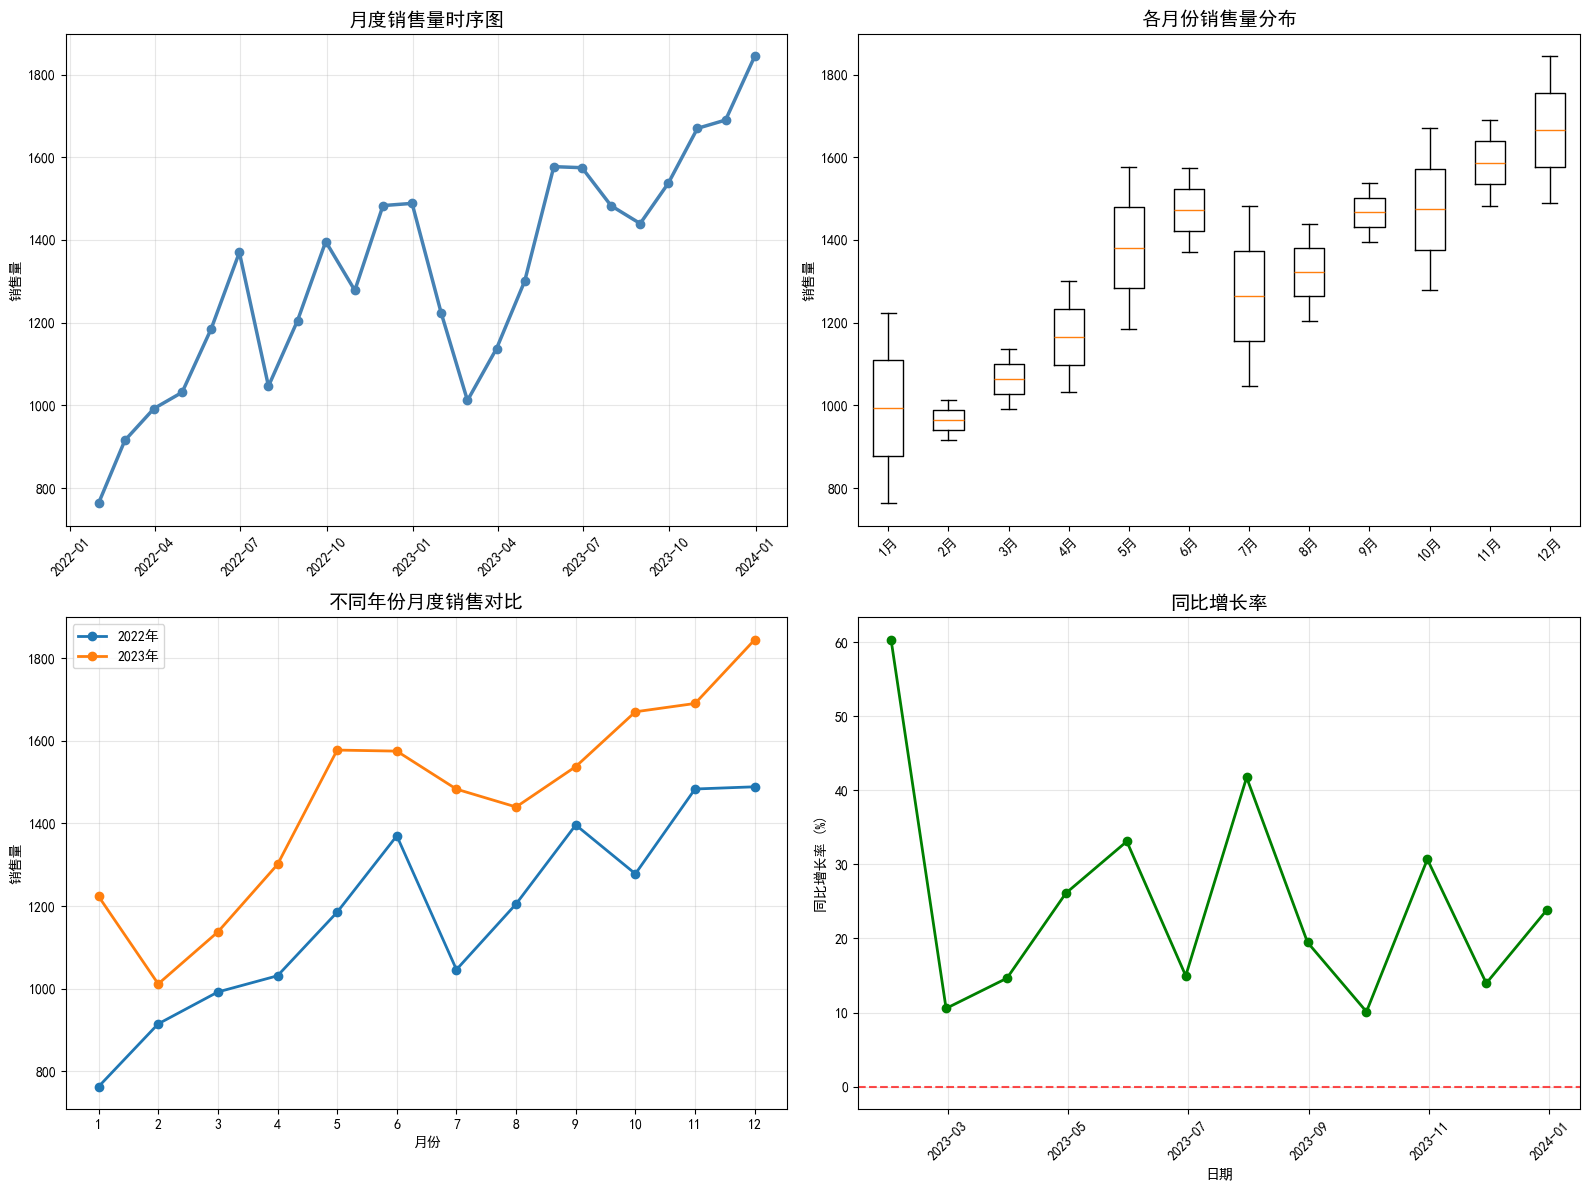


各月份销售统计:
       mean    std     min     max
1月    993.3  325.4   763.1  1223.4
2月    963.3   68.3   915.0  1011.6
3月   1064.7  102.7   992.1  1137.3
4月   1165.9  190.4  1031.3  1300.5
5月   1381.1  277.3  1185.1  1577.2
6月   1472.2  144.9  1369.8  1574.6
7月   1264.4  308.6  1046.2  1482.7
8月   1322.3  165.9  1205.0  1439.5
9月   1466.6   99.8  1396.0  1537.2
10月  1473.8  277.1  1277.9  1669.8
11月  1586.5  146.3  1483.0  1689.9
12月  1666.2  251.5  1488.4  1844.1

销售高峰月份: 12月 (平均销量: 1666)
销售低谷月份: 2月 (平均销量: 963)
峰谷差异: 703


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 销售量时序图
axes[0,0].plot(sales_data.index, sales_data['sales'], marker='o', linewidth=2.5, markersize=6, color='steelblue')
axes[0,0].set_title('月度销售量时序图', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('销售量')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].tick_params(axis='x', rotation=45)

# 按月份的箱线图（展示季节性）
monthly_sales = sales_data['sales'].groupby(sales_data.index.month)
month_data = [monthly_sales.get_group(i).values for i in range(1, 13) if i in monthly_sales.groups]
month_labels = [f'{i}月' for i in range(1, 13) if i in monthly_sales.groups]
axes[0,1].boxplot(month_data, labels=month_labels)
axes[0,1].set_title('各月份销售量分布', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('销售量')
axes[0,1].tick_params(axis='x', rotation=45)

# 年度对比
years = sales_data.index.year.unique()
for year in years:
    year_data = sales_data[sales_data.index.year == year]
    axes[1,0].plot(year_data.index.month, year_data['sales'], 
                   marker='o', label=f'{year}年', linewidth=2)
axes[1,0].set_title('不同年份月度销售对比', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('月份')
axes[1,0].set_ylabel('销售量')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xticks(range(1, 13))

# 同比增长率
if len(sales_data) >= 12:
    yoy_growth = sales_data['sales'].pct_change(12) * 100
    axes[1,1].plot(yoy_growth.index, yoy_growth, marker='o', color='green', linewidth=2)
    axes[1,1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    axes[1,1].set_title('同比增长率', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('日期')
    axes[1,1].set_ylabel('同比增长率 (%)')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 计算月度统计
monthly_stats = sales_data['sales'].groupby(sales_data.index.month).agg(['mean', 'std', 'min', 'max'])
monthly_stats.index = ['1月','2月','3月','4月','5月','6月','7月','8月','9月','10月','11月','12月'][:len(monthly_stats)]
print("\n各月份销售统计:")
print(monthly_stats.round(1))

# 找出销售高峰和低谷
peak_month = monthly_stats['mean'].idxmax()
trough_month = monthly_stats['mean'].idxmin()
print(f"\n销售高峰月份: {peak_month} (平均销量: {monthly_stats.loc[peak_month, 'mean']:.0f})")
print(f"销售低谷月份: {trough_month} (平均销量: {monthly_stats.loc[trough_month, 'mean']:.0f})")
print(f"峰谷差异: {monthly_stats.loc[peak_month, 'mean'] - monthly_stats.loc[trough_month, 'mean']:.0f}")

# ==========================================
# 第三步：季节性分解
# ==========================================


3. 季节性分解分析
------------------------------


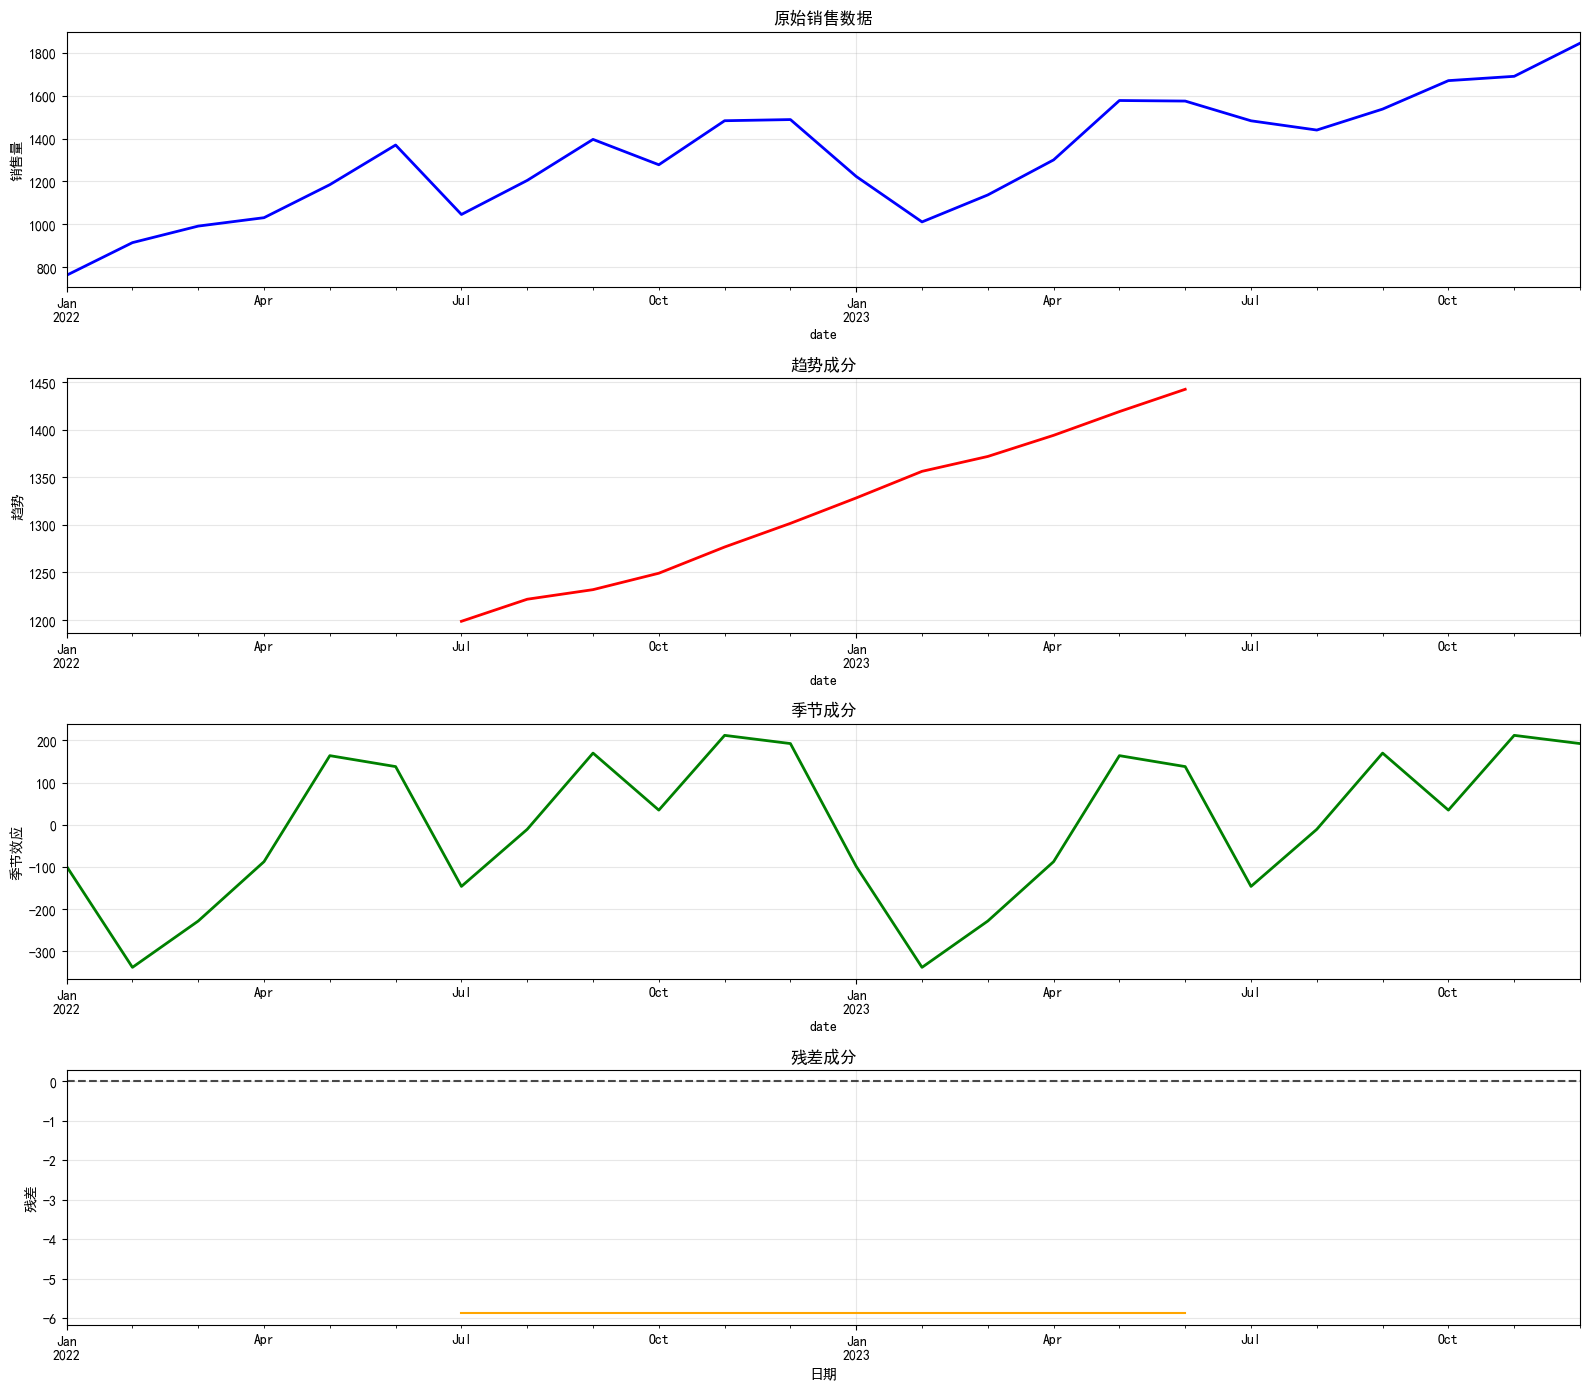

季节性分析结果:
季节性强度 (标准差): 182.0
最强正季节效应: 212.2 (第11月)
最强负季节效应: -338.8 (第2月)
平均月度增长趋势: 22.6 单位/月


In [7]:
print("\n3. 季节性分解分析")
print("-" * 30)

# 执行季节性分解
decomposition = seasonal_decompose(sales_data['sales'], model='additive', period=12)

# 可视化分解结果
fig, axes = plt.subplots(4, 1, figsize=(16, 14))

# 原始序列
decomposition.observed.plot(ax=axes[0], title='原始销售数据', color='blue', linewidth=2)
axes[0].set_ylabel('销售量')
axes[0].grid(True, alpha=0.3)

# 趋势成分
decomposition.trend.plot(ax=axes[1], title='趋势成分', color='red', linewidth=2)
axes[1].set_ylabel('趋势')
axes[1].grid(True, alpha=0.3)

# 季节成分
decomposition.seasonal.plot(ax=axes[2], title='季节成分', color='green', linewidth=2)
axes[2].set_ylabel('季节效应')
axes[2].grid(True, alpha=0.3)

# 残差成分
decomposition.resid.plot(ax=axes[3], title='残差成分', color='orange', linewidth=1.5)
axes[3].axhline(y=0, color='black', linestyle='--', alpha=0.7)
axes[3].set_ylabel('残差')
axes[3].set_xlabel('日期')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 分析季节性模式
seasonal_pattern = decomposition.seasonal[:12]  # 一年的季节模式
print("季节性分析结果:")
print(f"季节性强度 (标准差): {seasonal_pattern.std():.1f}")
print(f"最强正季节效应: {seasonal_pattern.max():.1f} (第{seasonal_pattern.idxmax().month}月)")
print(f"最强负季节效应: {seasonal_pattern.min():.1f} (第{seasonal_pattern.idxmin().month}月)")

# 趋势分析
trend_component = decomposition.trend.dropna()
trend_slope = np.polyfit(range(len(trend_component)), trend_component, 1)[0]
print(f"平均月度增长趋势: {trend_slope:.1f} 单位/月")

# ==========================================
# 第四步：平稳性检验
# ==========================================


4. 平稳性检验
------------------------------

原始销售序列:
ADF统计量: -1.4099
p值: 0.577503
ADF检验结论: 序列非平稳
KPSS统计量: 0.6300
KPSS p值: 0.019905
KPSS检验结论: 序列非平稳

一阶差分序列:
ADF统计量: -4.2668
p值: 0.000507
ADF检验结论: 序列平稳
KPSS统计量: 0.1575
KPSS p值: 0.100000
KPSS检验结论: 序列平稳

季节差分序列 (12期):
ADF统计量: -1.9009
p值: 0.331656
ADF检验结论: 序列非平稳
KPSS统计量: 0.2181
KPSS p值: 0.100000
KPSS检验结论: 序列平稳

一阶+季节差分序列:
ADF统计量: -4.5127
p值: 0.000186
ADF检验结论: 序列平稳
KPSS统计量: 0.5000
KPSS p值: 0.041667
KPSS检验结论: 序列非平稳


C:\Users\mcq\AppData\Local\Temp\ipykernel_7876\2888285515.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pvalue, kpss_lags, kpss_crit = kpss(data.dropna())
C:\Users\mcq\AppData\Local\Temp\ipykernel_7876\2888285515.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pvalue, kpss_lags, kpss_crit = kpss(data.dropna())


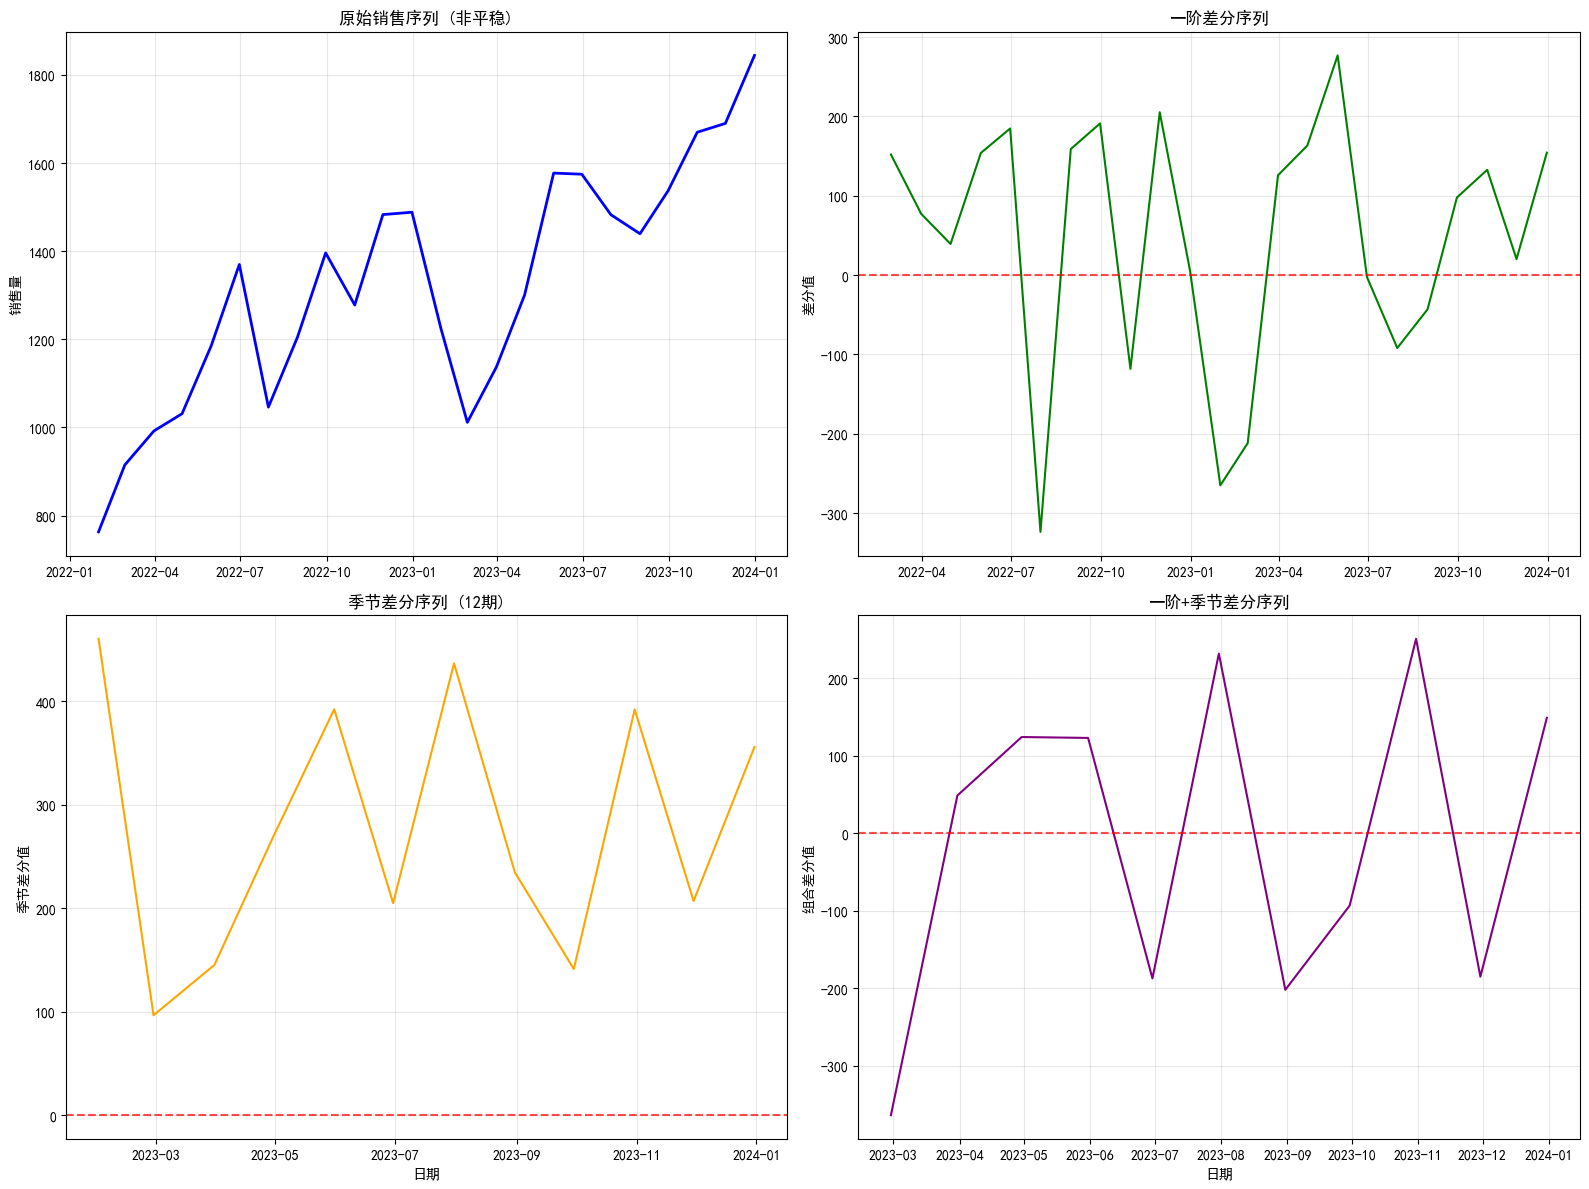


差分阶数确定:
普通差分次数 (d): 1
季节差分次数 (D): 1
季节周期 (s): 12


In [8]:
print("\n4. 平稳性检验")
print("-" * 30)

def comprehensive_stationarity_test(data, title):
    """
    综合平稳性检验
    """
    print(f"\n{title}:")
    
    # ADF检验
    adf_result = adfuller(data.dropna())
    print(f"ADF统计量: {adf_result[0]:.4f}")
    print(f"p值: {adf_result[1]:.6f}")
    
    if adf_result[1] <= 0.05:
        print("ADF检验结论: 序列平稳")
        is_stationary = True
    else:
        print("ADF检验结论: 序列非平稳")
        is_stationary = False
    
    # KPSS检验（互补检验）
    try:
        from statsmodels.tsa.stattools import kpss
        kpss_stat, kpss_pvalue, kpss_lags, kpss_crit = kpss(data.dropna())
        print(f"KPSS统计量: {kpss_stat:.4f}")
        print(f"KPSS p值: {kpss_pvalue:.6f}")
        
        if kpss_pvalue >= 0.05:
            print("KPSS检验结论: 序列平稳")
        else:
            print("KPSS检验结论: 序列非平稳")
    except:
        print("KPSS检验失败")
    
    return is_stationary

# 原始序列检验
original_stationary = comprehensive_stationarity_test(sales_data['sales'], "原始销售序列")

# 一阶差分检验
sales_diff1 = sales_data['sales'].diff().dropna()
diff1_stationary = comprehensive_stationarity_test(sales_diff1, "一阶差分序列")

# 季节差分检验
sales_seasonal_diff = sales_data['sales'].diff(12).dropna()
seasonal_diff_stationary = comprehensive_stationarity_test(sales_seasonal_diff, "季节差分序列 (12期)")

# 一阶+季节差分检验
sales_both_diff = sales_data['sales'].diff().diff(12).dropna()
both_diff_stationary = comprehensive_stationarity_test(sales_both_diff, "一阶+季节差分序列")

# 平稳性检验可视化
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 原始序列
axes[0,0].plot(sales_data['sales'], color='blue', linewidth=2)
axes[0,0].set_title('原始销售序列 (非平稳)', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('销售量')
axes[0,0].grid(True, alpha=0.3)

# 一阶差分
axes[0,1].plot(sales_diff1, color='green', linewidth=1.5)
axes[0,1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[0,1].set_title('一阶差分序列', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('差分值')
axes[0,1].grid(True, alpha=0.3)

# 季节差分
axes[1,0].plot(sales_seasonal_diff, color='orange', linewidth=1.5)
axes[1,0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[1,0].set_title('季节差分序列 (12期)', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('季节差分值')
axes[1,0].set_xlabel('日期')
axes[1,0].grid(True, alpha=0.3)

# 一阶+季节差分
axes[1,1].plot(sales_both_diff, color='purple', linewidth=1.5)
axes[1,1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[1,1].set_title('一阶+季节差分序列', fontsize=12, fontweight='bold')
axes[1,1].set_ylabel('组合差分值')
axes[1,1].set_xlabel('日期')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 确定差分阶数
print(f"\n差分阶数确定:")
print(f"普通差分次数 (d): 1")
print(f"季节差分次数 (D): 1")
print(f"季节周期 (s): 12")

# ==========================================
# 第五步：ACF和PACF分析
# ==========================================


5. ACF和PACF分析
------------------------------


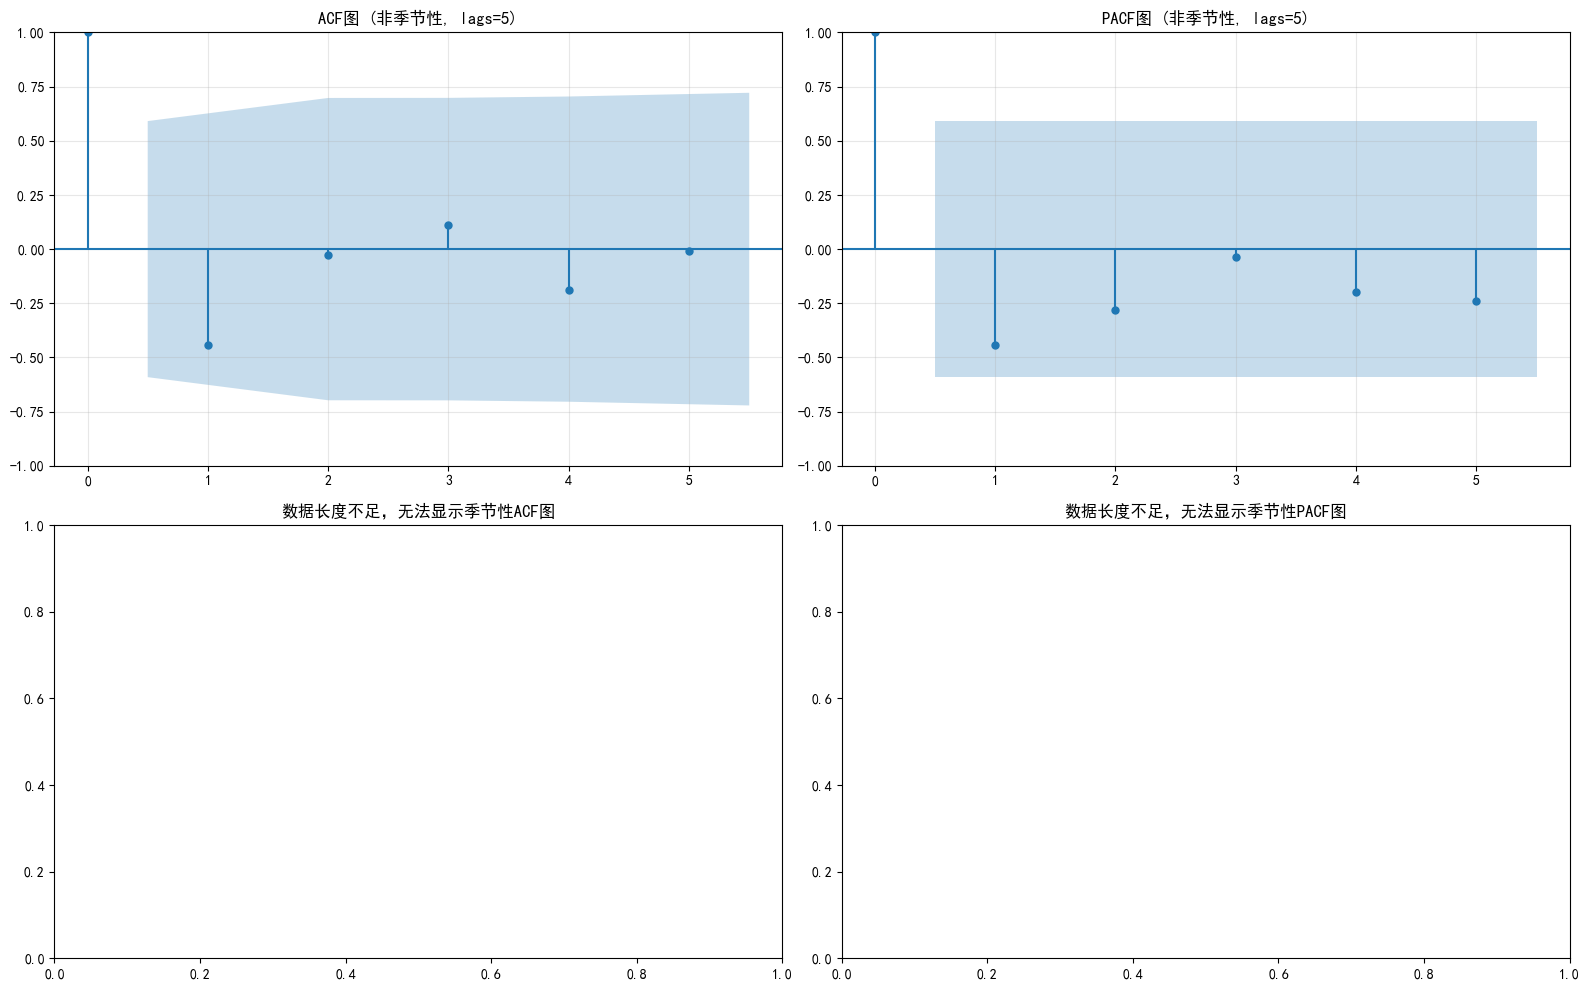

In [9]:
print("\n5. ACF和PACF分析")
print("-" * 30)

# 对平稳化后的序列进行ACF/PACF分析
if len(sales_both_diff) > 0:
    analysis_data = sales_both_diff.dropna()
else:
    analysis_data = sales_diff1

# 计算合适的lags参数，确保不超过数据长度的一半
max_lags = min(20, len(analysis_data) // 2)

# 绘制ACF和PACF图
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 非季节性ACF和PACF
plot_acf(analysis_data, ax=axes[0,0], lags=max_lags, title=f'ACF图 (非季节性, lags={max_lags})')
axes[0,0].grid(True, alpha=0.3)

plot_pacf(analysis_data, ax=axes[0,1], lags=max_lags, title=f'PACF图 (非季节性, lags={max_lags})')
axes[0,1].grid(True, alpha=0.3)

# 季节性ACF和PACF（如果数据足够长）
if len(analysis_data) > 24:
    seasonal_lags = min(36, len(analysis_data) // 2)
    plot_acf(analysis_data, ax=axes[1,0], lags=seasonal_lags, title=f'ACF图 (包含季节性, lags={seasonal_lags})')
    axes[1,0].grid(True, alpha=0.3)
    
    plot_pacf(analysis_data, ax=axes[1,1], lags=seasonal_lags, title=f'PACF图 (包含季节性, lags={seasonal_lags})')
    axes[1,1].grid(True, alpha=0.3)
else:
    axes[1,0].set_title('数据长度不足，无法显示季节性ACF图')
    axes[1,1].set_title('数据长度不足，无法显示季节性PACF图')

plt.tight_layout()
plt.show()

In [10]:
# 自动参数识别建议
def suggest_sarima_parameters(data, seasonal_period=12):
    """
    基于ACF/PACF特征建议SARIMA参数
    """
    from statsmodels.tsa.stattools import acf, pacf
    
    # 计算ACF和PACF
    acf_vals = acf(data, nlags=min(len(data)//4, 20), fft=False)
    pacf_vals = pacf(data, nlags=min(len(data)//4, 20))
    
    # 置信区间
    n = len(data)
    ci = 1.96 / np.sqrt(n)
    
    # 非季节性参数建议
    significant_pacf = sum(abs(pacf_vals[1:4]) > ci)  # 前3阶
    significant_acf = sum(abs(acf_vals[1:4]) > ci)    # 前3阶
    
    p_suggest = min(significant_pacf, 2)
    q_suggest = min(significant_acf, 2)
    
    # 季节性参数建议（简化版）
    if len(data) > seasonal_period:
        seasonal_acf = abs(acf_vals[seasonal_period]) if len(acf_vals) > seasonal_period else 0
        seasonal_pacf = abs(pacf_vals[seasonal_period]) if len(pacf_vals) > seasonal_period else 0
        
        P_suggest = 1 if seasonal_pacf > ci else 0
        Q_suggest = 1 if seasonal_acf > ci else 0
    else:
        P_suggest = Q_suggest = 0
    
    return p_suggest, 1, q_suggest, P_suggest, 1, Q_suggest, seasonal_period

p, d, q, P, D, Q, s = suggest_sarima_parameters(analysis_data)
print(f"建议的SARIMA参数:")
print(f"非季节性部分 (p,d,q): ({p},{d},{q})")
print(f"季节性部分 (P,D,Q,s): ({P},{D},{Q},{s})")

建议的SARIMA参数:
非季节性部分 (p,d,q): (0,1,0)
季节性部分 (P,D,Q,s): (0,1,0,12)


# ==========================================
# 第六步：SARIMA模型网格搜索
# ==========================================

In [11]:
print("\n6. SARIMA模型网格搜索")
print("-" * 30)

def sarima_grid_search(data, max_order=2, seasonal_period=12):
    """
    SARIMA模型网格搜索
    """
    # 定义参数范围
    p = d = q = range(0, max_order + 1)
    P = D = Q = range(0, 2)  # 季节性参数通常较小
    
    # 生成所有参数组合
    pdq = list(itertools.product(p, [1], q))  # 固定d=1
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in itertools.product(P, [1], Q)]  # 固定D=1
    
    best_aic = float('inf')
    best_params = None
    best_seasonal_params = None
    results = []
    
    print("开始SARIMA参数网格搜索...")
    print("格式: SARIMA(p,d,q)(P,D,Q,s) - AIC值")
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(data, 
                               order=param,
                               seasonal_order=param_seasonal,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
                
                fitted_model = model.fit(disp=False)
                
                aic = fitted_model.aic
                bic = fitted_model.bic
                
                results.append({
                    'params': param,
                    'seasonal_params': param_seasonal,
                    'AIC': aic,
                    'BIC': bic
                })
                
                param_str = f"SARIMA{param}{param_seasonal}"
                print(f"{param_str} - AIC: {aic:.2f}")
                
                if aic < best_aic:
                    best_aic = aic
                    best_params = param
                    best_seasonal_params = param_seasonal
                    
            except Exception as e:
                param_str = f"SARIMA{param}{param_seasonal}"
                print(f"{param_str} - 拟合失败")
                continue
    
    results_df = pd.DataFrame(results)
    
    print(f"\n最优SARIMA参数: {best_params}{best_seasonal_params}")
    print(f"最佳AIC值: {best_aic:.2f}")
    
    return best_params, best_seasonal_params, results_df

# 执行网格搜索
best_params, best_seasonal_params, search_results = sarima_grid_search(sales_data['sales'])

# 显示前10个最佳模型
if not search_results.empty:
    print("\n前10个最佳模型（按AIC排序）:")
    top_models = search_results.nsmallest(10, 'AIC')
    for idx, row in top_models.iterrows():
        params_str = f"SARIMA{row['params']}{row['seasonal_params']}"
        print(f"{params_str} - AIC: {row['AIC']:.2f}, BIC: {row['BIC']:.2f}")


6. SARIMA模型网格搜索
------------------------------
开始SARIMA参数网格搜索...
格式: SARIMA(p,d,q)(P,D,Q,s) - AIC值
SARIMA(0, 1, 0)(0, 1, 0, 12) - AIC: 133.14
SARIMA(0, 1, 0)(0, 1, 1, 12) - AIC: 4.00
SARIMA(0, 1, 0)(1, 1, 0, 12) - AIC: 4.00
SARIMA(0, 1, 0)(1, 1, 1, 12) - AIC: 6.00
SARIMA(0, 1, 1)(0, 1, 0, 12) - AIC: 114.09
SARIMA(0, 1, 1)(0, 1, 1, 12) - AIC: 6.00
SARIMA(0, 1, 1)(1, 1, 0, 12) - AIC: 6.00
SARIMA(0, 1, 1)(1, 1, 1, 12) - AIC: 8.00
SARIMA(0, 1, 2)(0, 1, 0, 12) - AIC: 103.00
SARIMA(0, 1, 2)(0, 1, 1, 12) - AIC: 8.00
SARIMA(0, 1, 2)(1, 1, 0, 12) - AIC: 8.00
SARIMA(0, 1, 2)(1, 1, 1, 12) - AIC: 10.00
SARIMA(1, 1, 0)(0, 1, 0, 12) - AIC: 131.51


d:\miniconda\envs\math\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\miniconda\envs\math\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\miniconda\envs\math\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\miniconda\envs\math\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\miniconda\envs\math\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init

SARIMA(1, 1, 0)(0, 1, 1, 12) - AIC: 6.00
SARIMA(1, 1, 0)(1, 1, 0, 12) - AIC: 6.00
SARIMA(1, 1, 0)(1, 1, 1, 12) - AIC: 8.00
SARIMA(1, 1, 1)(0, 1, 0, 12) - AIC: 114.71
SARIMA(1, 1, 1)(0, 1, 1, 12) - AIC: 8.00
SARIMA(1, 1, 1)(1, 1, 0, 12) - AIC: 8.00
SARIMA(1, 1, 1)(1, 1, 1, 12) - AIC: 10.00
SARIMA(1, 1, 2)(0, 1, 0, 12) - AIC: 105.42
SARIMA(1, 1, 2)(0, 1, 1, 12) - AIC: 10.00
SARIMA(1, 1, 2)(1, 1, 0, 12) - AIC: 10.00
SARIMA(1, 1, 2)(1, 1, 1, 12) - AIC: 12.00
SARIMA(2, 1, 0)(0, 1, 0, 12) - AIC: 117.75
SARIMA(2, 1, 0)(0, 1, 1, 12) - AIC: 8.00
SARIMA(2, 1, 0)(1, 1, 0, 12) - AIC: 8.00
SARIMA(2, 1, 0)(1, 1, 1, 12) - AIC: 10.00


d:\miniconda\envs\math\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\miniconda\envs\math\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\miniconda\envs\math\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\miniconda\envs\math\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\miniconda\envs\math\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init

SARIMA(2, 1, 1)(0, 1, 0, 12) - AIC: 116.62
SARIMA(2, 1, 1)(0, 1, 1, 12) - AIC: 10.00
SARIMA(2, 1, 1)(1, 1, 0, 12) - AIC: 10.00
SARIMA(2, 1, 1)(1, 1, 1, 12) - AIC: 12.00
SARIMA(2, 1, 2)(0, 1, 0, 12) - AIC: 107.30
SARIMA(2, 1, 2)(0, 1, 1, 12) - AIC: 12.00
SARIMA(2, 1, 2)(1, 1, 0, 12) - AIC: 12.00
SARIMA(2, 1, 2)(1, 1, 1, 12) - AIC: 14.00

最优SARIMA参数: (0, 1, 0)(0, 1, 1, 12)
最佳AIC值: 4.00

前10个最佳模型（按AIC排序）:
SARIMA(0, 1, 0)(0, 1, 1, 12) - AIC: 4.00, BIC: nan
SARIMA(0, 1, 0)(1, 1, 0, 12) - AIC: 4.00, BIC: nan
SARIMA(0, 1, 0)(1, 1, 1, 12) - AIC: 6.00, BIC: nan
SARIMA(0, 1, 1)(0, 1, 1, 12) - AIC: 6.00, BIC: nan
SARIMA(0, 1, 1)(1, 1, 0, 12) - AIC: 6.00, BIC: nan
SARIMA(1, 1, 0)(0, 1, 1, 12) - AIC: 6.00, BIC: nan
SARIMA(1, 1, 0)(1, 1, 0, 12) - AIC: 6.00, BIC: nan
SARIMA(0, 1, 1)(1, 1, 1, 12) - AIC: 8.00, BIC: nan
SARIMA(0, 1, 2)(0, 1, 1, 12) - AIC: 8.00, BIC: nan
SARIMA(0, 1, 2)(1, 1, 0, 12) - AIC: 8.00, BIC: nan


d:\miniconda\envs\math\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\miniconda\envs\math\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\miniconda\envs\math\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\miniconda\envs\math\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\miniconda\envs\math\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init

# ==========================================
# 第七步：最优SARIMA模型拟合
# ==========================================

In [12]:
print("\n7. 最优SARIMA模型拟合")
print("-" * 30)

# 使用最优参数拟合SARIMA模型
optimal_sarima = SARIMAX(sales_data['sales'],
                        order=best_params,
                        seasonal_order=best_seasonal_params,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

fitted_sarima = optimal_sarima.fit(disp=False)

# 显示模型摘要
print("SARIMA模型拟合结果:")
print(f"模型规格: SARIMA{best_params}{best_seasonal_params}")
print(f"AIC: {fitted_sarima.aic:.2f}")
print(f"BIC: {fitted_sarima.bic:.2f}")
print(f"对数似然值: {fitted_sarima.llf:.2f}")

# 模型参数显著性检验
print("\n模型参数估计:")
print(fitted_sarima.summary().tables[1])


7. 最优SARIMA模型拟合
------------------------------
SARIMA模型拟合结果:
模型规格: SARIMA(0, 1, 0)(0, 1, 1, 12)
AIC: 4.00
BIC: nan
对数似然值: 0.00

模型参数估计:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12            0         -0        nan        nan           0           0
sigma2      3.513e+04         -0       -inf      0.000    3.51e+04    3.51e+04


d:\miniconda\envs\math\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\miniconda\envs\math\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


# ==========================================
# 第八步：模型诊断
# ==========================================


8. 模型诊断
------------------------------
残差诊断统计:
残差均值: 25.4203
残差标准差: 287.3385
残差偏度: -0.4011
残差峰度: 2.8376

Ljung-Box检验 (前10滞后阶):
统计量: 4.1125
p值: 0.942130
残差序列为白噪声 (模型充分)


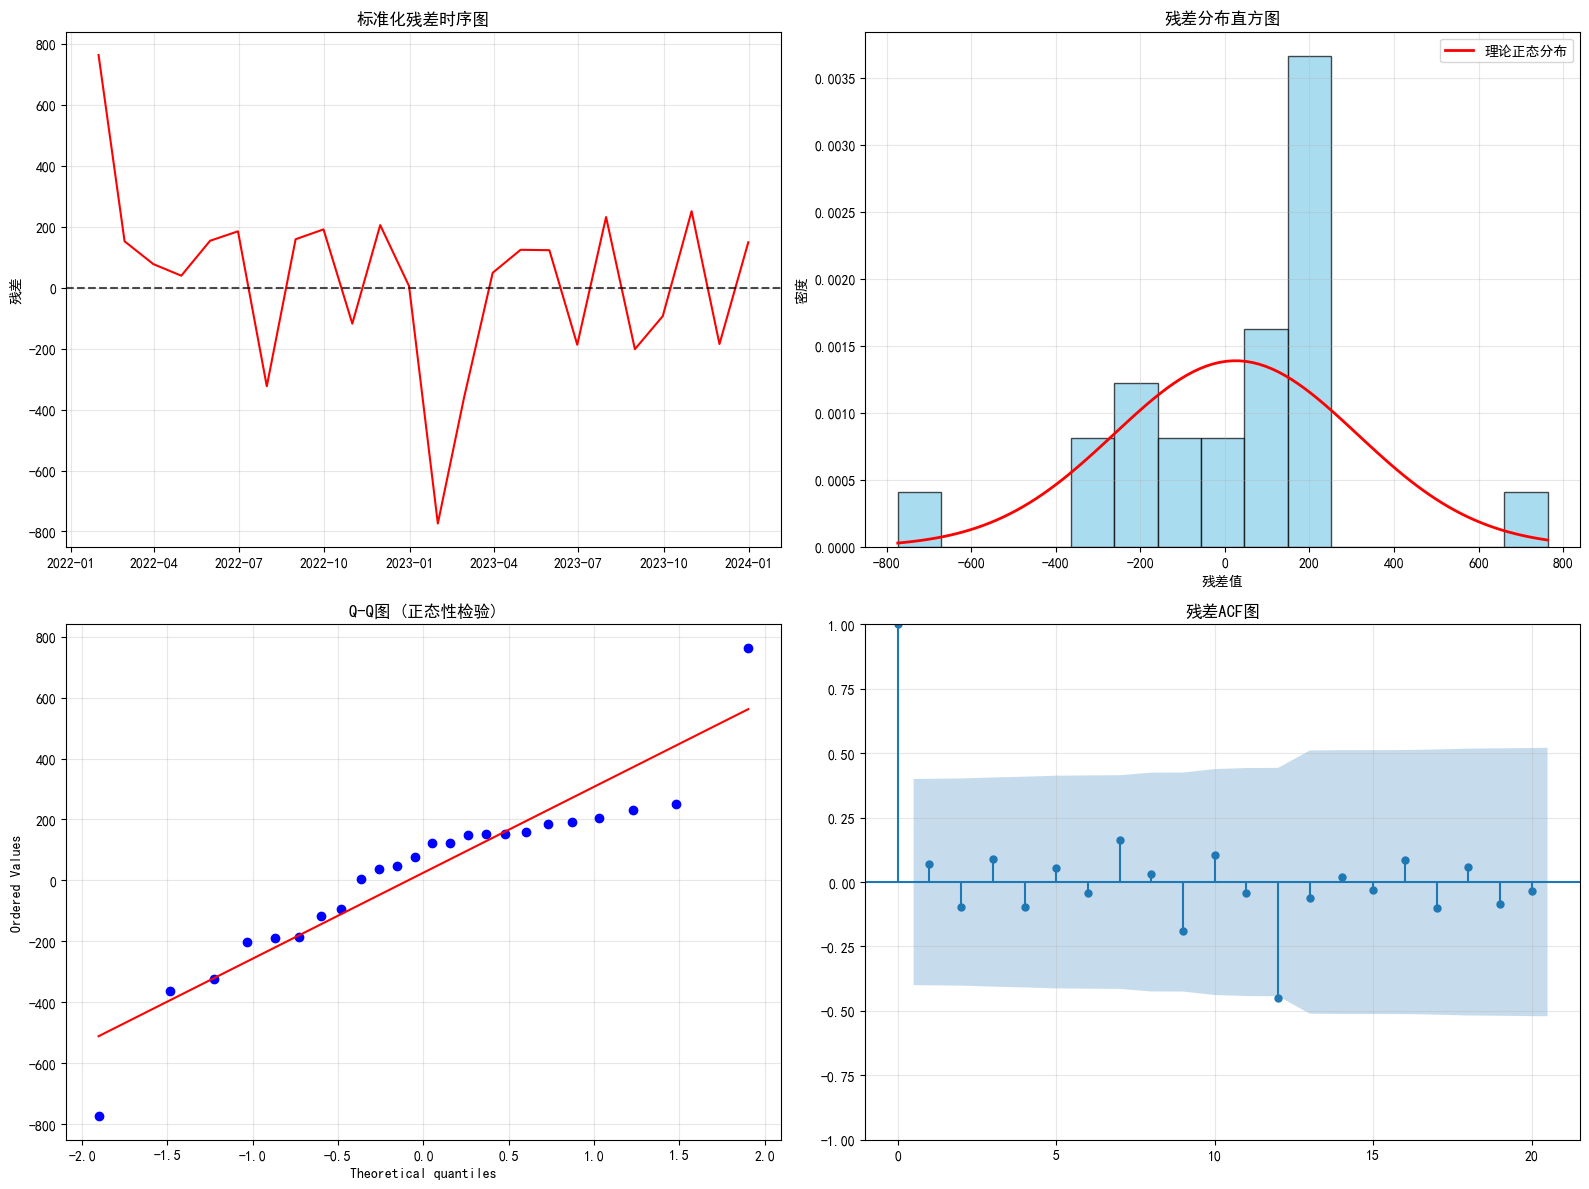


Jarque-Bera正态性检验:
统计量: 4.7259
p值: 0.094142
残差符合正态分布


In [13]:
print("\n8. 模型诊断")
print("-" * 30)

# 获取残差
residuals = fitted_sarima.resid

# 残差诊断统计
print("残差诊断统计:")
print(f"残差均值: {residuals.mean():.4f}")
print(f"残差标准差: {residuals.std():.4f}")
print(f"残差偏度: {residuals.skew():.4f}")
print(f"残差峰度: {residuals.kurtosis():.4f}")

# Ljung-Box检验（残差白噪声检验）
lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
print(f"\nLjung-Box检验 (前10滞后阶):")
print(f"统计量: {lb_test['lb_stat'].iloc[-1]:.4f}")
print(f"p值: {lb_test['lb_pvalue'].iloc[-1]:.6f}")
if lb_test['lb_pvalue'].iloc[-1] > 0.05:
    print("残差序列为白噪声 (模型充分)")
else:
    print("残差序列存在自相关 (模型可能不充分)")

# 模型诊断可视化
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 残差时序图
axes[0,0].plot(residuals, linewidth=1.5, color='red')
axes[0,0].axhline(y=0, color='black', linestyle='--', alpha=0.7)
axes[0,0].set_title('标准化残差时序图', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('残差')
axes[0,0].grid(True, alpha=0.3)

# 残差直方图
axes[0,1].hist(residuals, bins=15, density=True, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].set_title('残差分布直方图', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('残差值')
axes[0,1].set_ylabel('密度')
axes[0,1].grid(True, alpha=0.3)

# 叠加正态分布曲线
x = np.linspace(residuals.min(), residuals.max(), 100)
axes[0,1].plot(x, (1/np.sqrt(2*np.pi*residuals.var())) * np.exp(-0.5*((x-residuals.mean())/residuals.std())**2), 
               'r-', linewidth=2, label='理论正态分布')
axes[0,1].legend()

# Q-Q图（正态性检验）
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q图 (正态性检验)', fontsize=12, fontweight='bold')
axes[1,0].grid(True, alpha=0.3)

# 残差ACF图
plot_acf(residuals, ax=axes[1,1], lags=20, title='残差ACF图')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Jarque-Bera正态性检验
from scipy.stats import jarque_bera
jb_stat, jb_pvalue = jarque_bera(residuals)
print(f"\nJarque-Bera正态性检验:")
print(f"统计量: {jb_stat:.4f}")
print(f"p值: {jb_pvalue:.6f}")
if jb_pvalue > 0.05:
    print("残差符合正态分布")
else:
    print("残差不符合正态分布")


# ==========================================
# 第九步：模型预测
# ==========================================

In [14]:
print("\n9. 模型预测")
print("-" * 30)

# 设置预测参数
forecast_periods = 6  # 预测未来6个月
confidence_level = 0.95

# 进行预测
forecast_result = fitted_sarima.get_forecast(steps=forecast_periods)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int(alpha=1-confidence_level)

# 创建预测日期索引
last_date = sales_data.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                              periods=forecast_periods, freq='M')

# 创建预测结果DataFrame
forecast_df = pd.DataFrame({
    'forecast': forecast_mean.values,
    'lower_ci': forecast_ci.iloc[:, 0].values,
    'upper_ci': forecast_ci.iloc[:, 1].values
}, index=forecast_index)

print("预测结果:")
print(forecast_df.round(0))

# 计算预测区间宽度
forecast_df['interval_width'] = forecast_df['upper_ci'] - forecast_df['lower_ci']
print(f"\n平均预测区间宽度: {forecast_df['interval_width'].mean():.0f}")
print(f"预测不确定性系数: {(forecast_df['interval_width'].mean() / forecast_df['forecast'].mean() * 100):.1f}%")


9. 模型预测
------------------------------
预测结果:
            forecast  lower_ci  upper_ci
2024-01-31    1579.0    1212.0    1946.0
2024-02-29    1367.0     848.0    1887.0
2024-03-31    1493.0     857.0    2129.0
2024-04-30    1656.0     921.0    2391.0
2024-05-31    1933.0    1111.0    2754.0
2024-06-30    1930.0    1030.0    2830.0

平均预测区间宽度: 1326
预测不确定性系数: 79.9%


# ==========================================
# 第十步：预测可视化
# ==========================================


10. 预测结果可视化
------------------------------


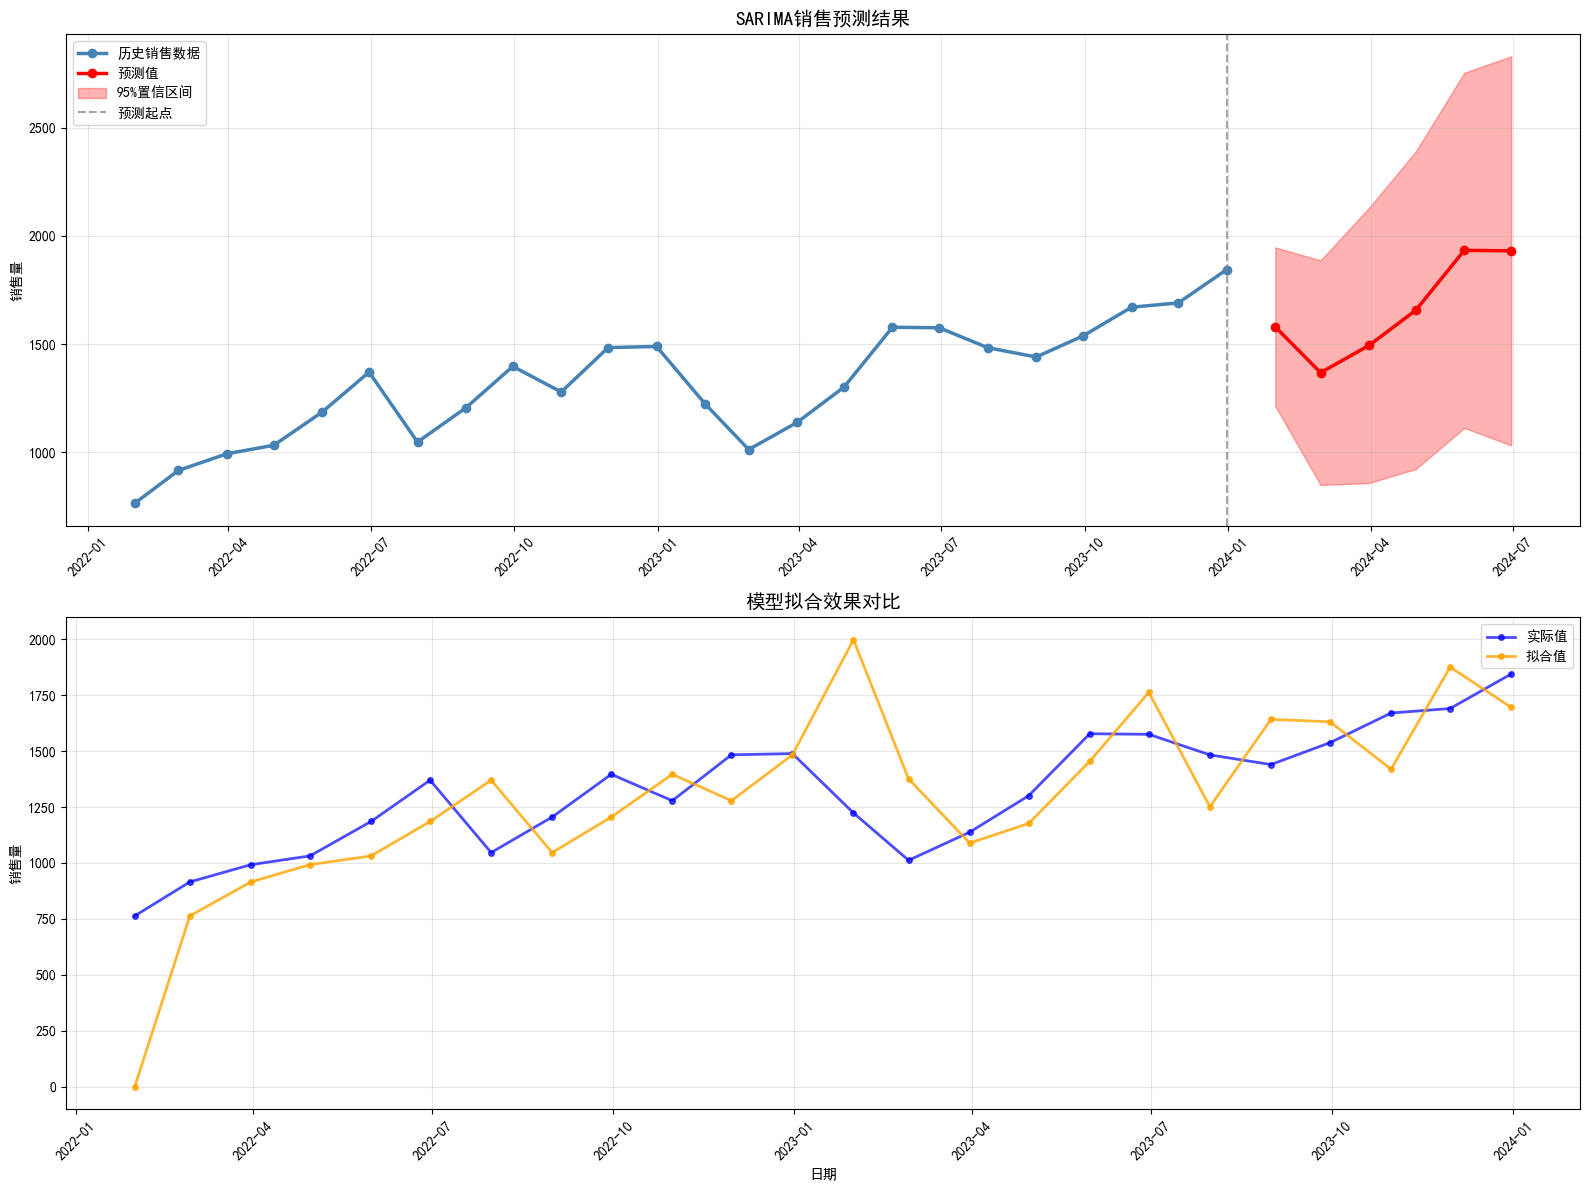

In [15]:
print("\n10. 预测结果可视化")
print("-" * 30)

# 创建预测可视化
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# 整体预测图
# 历史数据
axes[0].plot(sales_data.index, sales_data['sales'], 'o-', linewidth=2.5, markersize=6, 
             color='steelblue', label='历史销售数据')

# 预测数据
axes[0].plot(forecast_index, forecast_df['forecast'], 'o-', linewidth=2.5, markersize=6,
             color='red', label='预测值')

# 置信区间
axes[0].fill_between(forecast_index, forecast_df['lower_ci'], forecast_df['upper_ci'],
                     alpha=0.3, color='red', label=f'{int(confidence_level*100)}%置信区间')

axes[0].axvline(x=sales_data.index[-1], color='gray', linestyle='--', alpha=0.7, label='预测起点')
axes[0].set_title('SARIMA销售预测结果', fontsize=14, fontweight='bold')
axes[0].set_ylabel('销售量')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# 模型拟合效果图
fitted_values = fitted_sarima.fittedvalues
axes[1].plot(sales_data.index, sales_data['sales'], 'o-', linewidth=2, markersize=4,
             color='blue', label='实际值', alpha=0.7)
axes[1].plot(sales_data.index, fitted_values, 'o-', linewidth=2, markersize=4,
             color='orange', label='拟合值', alpha=0.8)

axes[1].set_title('模型拟合效果对比', fontsize=14, fontweight='bold')
axes[1].set_ylabel('销售量')
axes[1].set_xlabel('日期')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ==========================================
# 第十一步：预测精度评估
# ==========================================


11. 预测精度评估
------------------------------
样本内拟合精度:
MAE (平均绝对误差): 212.65
MSE (均方误差): 79769.49
RMSE (均方根误差): 282.43
MAPE (平均绝对百分比误差): 18.26%
相对RMSE: 21.42%

滚动预测验证 (最后6个月):
样本外预测精度:
MAE: 110.83
RMSE: 139.25
MAPE: 6.89%


d:\miniconda\envs\math\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\miniconda\envs\math\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


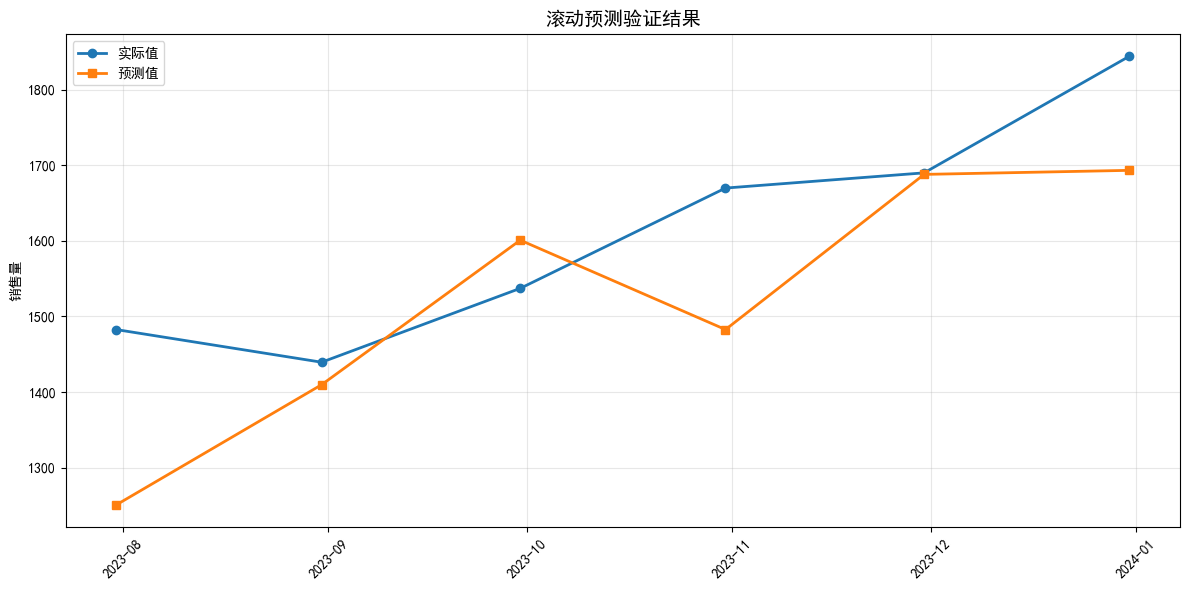

In [16]:
print("\n11. 预测精度评估")
print("-" * 30)

# 计算拟合精度指标
mae_fit = mean_absolute_error(sales_data['sales'], fitted_values)
mse_fit = mean_squared_error(sales_data['sales'], fitted_values)
rmse_fit = np.sqrt(mse_fit)
mape_fit = np.mean(np.abs((sales_data['sales'] - fitted_values) / sales_data['sales'])) * 100

print("样本内拟合精度:")
print(f"MAE (平均绝对误差): {mae_fit:.2f}")
print(f"MSE (均方误差): {mse_fit:.2f}")
print(f"RMSE (均方根误差): {rmse_fit:.2f}")
print(f"MAPE (平均绝对百分比误差): {mape_fit:.2f}%")

# 相对精度
relative_rmse = rmse_fit / sales_data['sales'].mean() * 100
print(f"相对RMSE: {relative_rmse:.2f}%")

# 如果有足够的历史数据，进行滚动预测验证
if len(sales_data) > 18:
    print("\n滚动预测验证 (最后6个月):")
    
    # 用前面的数据训练，预测后面的数据
    train_size = len(sales_data) - 6
    train_data = sales_data['sales'][:train_size]
    test_data = sales_data['sales'][train_size:]
    
    # 重新拟合模型
    validation_model = SARIMAX(train_data,
                              order=best_params,
                              seasonal_order=best_seasonal_params,
                              enforce_stationarity=False,
                              enforce_invertibility=False)
    
    validation_fitted = validation_model.fit(disp=False)
    
    # 预测测试期
    validation_forecast = validation_fitted.get_forecast(steps=len(test_data))
    validation_pred = validation_forecast.predicted_mean
    
    # 计算预测精度
    mae_test = mean_absolute_error(test_data, validation_pred)
    mse_test = mean_squared_error(test_data, validation_pred)
    rmse_test = np.sqrt(mse_test)
    mape_test = np.mean(np.abs((test_data - validation_pred) / test_data)) * 100
    
    print(f"样本外预测精度:")
    print(f"MAE: {mae_test:.2f}")
    print(f"RMSE: {rmse_test:.2f}")
    print(f"MAPE: {mape_test:.2f}%")
    
    # 预测vs实际对比
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(test_data.index, test_data.values, 'o-', label='实际值', linewidth=2, markersize=6)
    ax.plot(test_data.index, validation_pred.values, 's-', label='预测值', linewidth=2, markersize=6)
    ax.set_title('滚动预测验证结果', fontsize=14, fontweight='bold')
    ax.set_ylabel('销售量')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ==========================================
# 第十二步：业务解读与建议
# ==========================================

In [17]:
print("\n12. 业务解读与建议")
print("=" * 50)

# 预测趋势分析
forecast_growth = (forecast_df['forecast'].iloc[-1] - sales_data['sales'].iloc[-1]) / sales_data['sales'].iloc[-1] * 100
print(f"预测期间总体增长: {forecast_growth:.1f}%")

# 月度预测增长
monthly_growth = forecast_df['forecast'].pct_change().dropna() * 100
print(f"预测期间月均增长: {monthly_growth.mean():.1f}%")

# 识别预测期内的高峰和低谷
forecast_peak_month = forecast_df['forecast'].idxmax().strftime('%Y年%m月')
forecast_peak_value = forecast_df['forecast'].max()
forecast_trough_month = forecast_df['forecast'].idxmin().strftime('%Y年%m月')
forecast_trough_value = forecast_df['forecast'].min()

print(f"\n预测期间销售高峰: {forecast_peak_month} ({forecast_peak_value:.0f})")
print(f"预测期间销售低谷: {forecast_trough_month} ({forecast_trough_value:.0f})")

# 季节性洞察
print(f"\n季节性模式分析:")
seasonal_months = ['11月', '12月', '1月', '2月']
current_forecast_months = [idx.strftime('%m月') for idx in forecast_index]
seasonal_in_forecast = [month for month in seasonal_months if month in current_forecast_months]

if seasonal_in_forecast:
    print(f"预测期包含季节性月份: {', '.join(seasonal_in_forecast)}")
    print("建议加强库存准备和营销投入")

# 风险评估
max_uncertainty = forecast_df['interval_width'].max()
high_uncertainty_months = forecast_df[forecast_df['interval_width'] > forecast_df['interval_width'].quantile(0.8)]

print(f"\n风险评估:")
print(f"最大预测不确定性: {max_uncertainty:.0f} (±{max_uncertainty/2:.0f})")
if not high_uncertainty_months.empty:
    high_risk_months = [idx.strftime('%Y年%m月') for idx in high_uncertainty_months.index]
    print(f"高不确定性月份: {', '.join(high_risk_months)}")

# 业务建议
print(f"\n业务建议:")
print("1. 库存管理:")
print(f"   - 建议安全库存水平: {forecast_df['upper_ci'].max():.0f}")
print(f"   - 最低库存需求: {forecast_df['lower_ci'].min():.0f}")

print("2. 营销策略:")
if forecast_growth > 0:
    print(f"   - 预测呈增长趋势，可适当增加营销投入")
else:
    print(f"   - 预测呈下降趋势，需要制定促销策略")

print("3. 生产计划:")
total_forecast_demand = forecast_df['forecast'].sum()
print(f"   - 未来{forecast_periods}个月总需求预测: {total_forecast_demand:.0f}")
print(f"   - 月均需求: {total_forecast_demand/forecast_periods:.0f}")

# ==========================================
# 第十三步：模型持续监控建议
# ==========================================

print("\n13. 模型监控与更新建议")
print("=" * 40)

print("模型监控指标:")
print("1. 预测准确性监控:")
print(f"   - 当前MAPE: {mape_fit:.2f}%")
print(f"   - 建议预警阈值: MAPE > {mape_fit*1.5:.1f}%")

print("\n2. 残差监控:")
print(f"   - 当前残差标准差: {residuals.std():.2f}")
print(f"   - 建议监控新残差是否超出 ±{2*residuals.std():.1f}")

print("\n3. 模型更新建议:")
print("   - 建议每季度重新评估模型参数")
print("   - 当连续3个月预测误差超过阈值时重新建模")
print("   - 如有重大业务变化（促销、新产品等）应及时更新模型")

# 保存预测结果
print("\n14. 结果保存")
print("-" * 20)

# 创建完整的结果报告
results_summary = {
    '模型规格': f"SARIMA{best_params}{best_seasonal_params}",
    'AIC': fitted_sarima.aic,
    'BIC': fitted_sarima.bic,
    '拟合MAPE': f"{mape_fit:.2f}%",
    '拟合RMSE': f"{rmse_fit:.2f}",
    '预测期间': f"{forecast_periods}个月",
    '平均月增长率': f"{monthly_growth.mean():.2f}%" if not monthly_growth.empty else "N/A"
}

print("模型摘要:")
for key, value in results_summary.items():
    print(f"{key}: {value}")

# 创建最终预测表
final_forecast_table = pd.DataFrame({
    '日期': forecast_index.strftime('%Y-%m'),
    '预测销量': forecast_df['forecast'].round(0).astype(int),
    '下界': forecast_df['lower_ci'].round(0).astype(int),
    '上界': forecast_df['upper_ci'].round(0).astype(int),
    '不确定性': forecast_df['interval_width'].round(0).astype(int)
})

print(f"\n最终预测表:")
print(final_forecast_table.to_string(index=False))

print("\n" + "="*60)
print("           SARIMA销售预测分析完成")
print("="*60)
print(f"预测完成时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("建议定期更新数据并重新评估模型性能")


12. 业务解读与建议
预测期间总体增长: 4.7%
预测期间月均增长: 4.7%

预测期间销售高峰: 2024年05月 (1933)
预测期间销售低谷: 2024年02月 (1367)

季节性模式分析:

风险评估:
最大预测不确定性: 1800 (±900)
高不确定性月份: 2024年06月

业务建议:
1. 库存管理:
   - 建议安全库存水平: 2830
   - 最低库存需求: 848
2. 营销策略:
   - 预测呈增长趋势，可适当增加营销投入
3. 生产计划:
   - 未来6个月总需求预测: 9959
   - 月均需求: 1660

13. 模型监控与更新建议
模型监控指标:
1. 预测准确性监控:
   - 当前MAPE: 18.26%
   - 建议预警阈值: MAPE > 27.4%

2. 残差监控:
   - 当前残差标准差: 287.34
   - 建议监控新残差是否超出 ±574.7

3. 模型更新建议:
   - 建议每季度重新评估模型参数
   - 当连续3个月预测误差超过阈值时重新建模
   - 如有重大业务变化（促销、新产品等）应及时更新模型

14. 结果保存
--------------------
模型摘要:
模型规格: SARIMA(0, 1, 0)(0, 1, 1, 12)
AIC: 4.0
BIC: nan
拟合MAPE: 18.26%
拟合RMSE: 282.43
预测期间: 6个月
平均月增长率: 4.66%

最终预测表:
     日期  预测销量   下界   上界  不确定性
2024-01  1579 1212 1946   735
2024-02  1367  848 1887  1039
2024-03  1493  857 2129  1273
2024-04  1656  921 2391  1469
2024-05  1933 1111 2754  1643
2024-06  1930 1030 2830  1800

           SARIMA销售预测分析完成
预测完成时间: 2025-09-27 21:22:49
建议定期更新数据并重新评估模型性能
